# <a id='env'>1. Setting up the Environment</a>

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore")

# <a id='env'>2. Data Import and Preprocessing</a>

In [32]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [33]:
merged = pd.concat([train, test], sort = False)
merged.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [34]:
print("merged shape:", merged.shape)
print(merged.dtypes)

merged shape: (1309, 12)
PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


## missing value 확인  
**missing value: Age, Cabin, Embarked (Survived는 제외)**

In [35]:
merged.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## 1) Cabin

In [36]:
merged.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [37]:
merged.Cabin.isnull().sum()

1014

In [38]:
merged.Cabin.value_counts(dropna = False).count()

187

### NaN을 X로 변환

In [39]:
merged.Cabin.fillna(value = 'X', inplace = True)

In [40]:
merged.Cabin = merged.Cabin.apply( lambda x : x[0])
merged.Cabin.value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin, dtype: int64

## 2) Name

In [41]:
merged.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

### 정규표현식을 통해 Title만 추출

In [42]:
merged['Title'] = merged.Name.str.extract('([A-Za-z]+)\.')
merged.Title.head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

In [43]:
merged.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Mlle          2
Ms            2
Major         2
Don           1
Countess      1
Sir           1
Lady          1
Mme           1
Dona          1
Capt          1
Jonkheer      1
Name: Title, dtype: int64

#### 애매한 Title을 수정

In [44]:
merged.Title.replace(to_replace = ['Dr', 'Rev', 'Col', 'Major', 'Capt'], value = 'Officer', inplace = True)
merged.Title.replace(to_replace = ['Dona', 'Jonkheer', 'Countess', 'Sir', 'Lady', 'Don'], value = 'Aristocrat', inplace = True)
merged.Title.replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'}, inplace = True)

In [45]:
merged.Title.value_counts()

Mr            757
Miss          264
Mrs           198
Master         61
Officer        23
Aristocrat      6
Name: Title, dtype: int64

## 3) SibSp, Parch

### Sibsp와 Parch를 합치고 binning을 함

In [46]:
merged['Family_size'] = merged.SibSp + merged.Parch + 1  # Adding 1 for single person
merged.Family_size.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family_size, dtype: int64

In [47]:
merged.Family_size.replace(to_replace = [1], value = 'single', inplace = True)
merged.Family_size.replace(to_replace = [2,3], value = 'small', inplace = True)
merged.Family_size.replace(to_replace = [4,5], value = 'medium', inplace = True)
merged.Family_size.replace(to_replace = [6, 7, 8, 11], value = 'large', inplace = True)

In [48]:
merged.Family_size.value_counts()

single    790
small     394
medium     65
large      60
Name: Family_size, dtype: int64

## 4) Ticket

In [49]:
merged.Ticket.head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [50]:
ticket = []
for x in list(merged.Ticket):
    if x.isdigit():
        ticket.append('N')
    else:
        ticket.append(x.replace('.','').replace('/','').strip().split(' ')[0])
        
merged.Ticket = ticket

In [51]:
merged.Ticket.value_counts()

N          957
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
SOC          8
C            8
SOPP         7
STONO2       7
SCAH         5
SCParis      5
PP           4
LINE         4
WEP          4
SOTONO2      3
FC           3
PPP          2
SCA4         2
SC           2
SWPP         2
LP           1
STONOQ       1
AQ4          1
SCA3         1
AS           1
CASOTON      1
AQ3          1
SOP          1
SP           1
SCOW         1
Fa           1
A            1
Name: Ticket, dtype: int64

### 맨 앞글자만 데이터로 사용

In [52]:
merged.Ticket = merged.Ticket.apply(lambda x : x[0])
merged.Ticket.value_counts()

N    957
P     98
S     98
C     77
A     42
W     19
F     13
L      5
Name: Ticket, dtype: int64

## 5) Embarked

### Embarked는 두 개의 missing value를 가지고 있으므로 적당 제일 많은 S로 채워준다.

In [53]:
merged.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [54]:
merged.Embarked.fillna(value = 'S', inplace = True)

## 6) Fare

### Fare는 두개의 missing value를 가지고 있으므로 적당하게  중앙값으로 채워준다.

In [55]:
merged.Fare.fillna(value = merged.Fare.median(), inplace = True)

## 7) Age

#### Age는 missing value가 많기 때문에 다른 변수와의 상관관계를 분석하고 그에 맞게 채워줘야 한다

In [57]:
correlation = merged.loc[:, ['Sex', 'Pclass', 'Embarked', 'Title', 'Family_size', 'Parch', 'SibSp', 'Cabin', 'Ticket']]
correlation = correlation.agg(LabelEncoder().fit_transform)
correlation['Age'] = merged.Age # Inserting Age in variable correlation.
correlation = correlation.set_index('Age').reset_index() # Move Age at index 0.

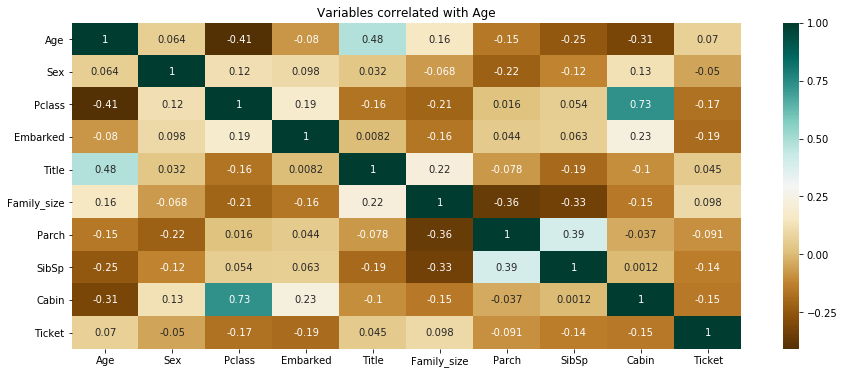

In [58]:
plt.figure(figsize=(15,6))
sns.heatmap(correlation.corr(), cmap ='BrBG',annot = True)
plt.title('Variables correlated with Age')
plt.show()

### Age는 Title과 Pclass와 큰 상관관계를 보인다.
### Age의 missing value를 title과 Pclass에 맞춰서 채운다

In [59]:
merged.Age = merged.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

### missing value를 다 채웠다.

In [60]:
merged.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
Family_size      0
dtype: int64

### binning Age

In [61]:
label_names = ['infant','child','teenager','young_adult','adult','aged']
cut_points = [0,5,12,18,35,60,81]

merged['Age_binned'] = pd.cut(merged.Age, cut_points, labels = label_names)
merged[['Age', 'Age_binned']].head(3)

,Age,Age_binned
0,22.0,young_adult
1,38.0,adult
2,26.0,young_adult


### binning Fare

In [62]:
groups = ['low','medium', 'Medium and above', 'little_high','high', 'very_high']
#cut_points = [-1, 130, 260, 390, 520] --> 0.79425
cut_points = [-1, 6.7, 14.4, 34, 77, 240, 520] # --> 0.80861
#cut_points = [-1, 6.7, 14.4, 34, 77, 170, 520] --> 0.77511

merged['Fare_binned'] = pd.cut(merged.Fare, cut_points, labels = groups)
merged[['Fare', 'Fare_binned']].head(3)

,Fare,Fare_binned
0,7.2500,medium
1,71.2833,little_high
2,7.9250,medium


## 불필요한 데이터 제거

In [63]:
merged.head(3)
merged.drop(columns = ['Name', 'Age', 'Fare'], inplace = True, axis = 1)
merged.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'Embarked', 'Title', 'Family_size', 'Age_binned',
       'Fare_binned'],
      dtype='object')

## 데이터 타입 조정하기

In [64]:
merged.dtypes

PassengerId       int64
Survived        float64
Pclass            int64
Sex              object
SibSp             int64
Parch             int64
Ticket           object
Cabin            object
Embarked         object
Title            object
Family_size      object
Age_binned     category
Fare_binned    category
dtype: object

In [65]:
merged.loc[:, ['Pclass', 'Sex', 'Embarked', 'Cabin', 'Title', 'Family_size', 'Ticket']] = merged.loc[:, ['Pclass', 'Sex', 'Embarked', 'Cabin', 'Title', 'Family_size', 'Ticket']].astype('category')
merged.Survived = merged.Survived.dropna().astype('int')
merged.dtypes

PassengerId       int64
Survived          int32
Pclass         category
Sex            category
SibSp             int64
Parch             int64
Ticket         category
Cabin          category
Embarked       category
Title          category
Family_size    category
Age_binned     category
Fare_binned    category
dtype: object

## 데이터 펼쳐주기(Encoding)

In [66]:
merged = pd.get_dummies(merged)

merged.head(3)

,PassengerId,Survived,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Ticket_A,...,Age_binned_teenager,Age_binned_young_adult,Age_binned_adult,Age_binned_aged,Fare_binned_low,Fare_binned_medium,Fare_binned_Medium and above,Fare_binned_little_high,Fare_binned_high,Fare_binned_very_high
0,1,0,1,0,0,0,1,0,1,1,...,0,1,0,0,0,1,0,0,0,0
1,2,1,1,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2,3,1,0,0,0,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0


## 합쳤던 훈련, 테스트 데이터를 분리하고 수정

In [67]:
seed = 43
df_train = merged.iloc[:891, :]
df_test  = merged.iloc[891:, :]

In [68]:
df_train = df_train.drop(columns = ['PassengerId'], axis = 1)
df_test = df_test.drop(columns = ['Survived'], axis = 1)

In [69]:
X_train = df_train.drop(columns = ['Survived'], axis = 1) # Input matrix as pandas dataframe (dim:891*47).
y_train = df_train['Survived'] # Output vector as pandas series (dim:891*1)

X_test  = df_test.drop("PassengerId", axis = 1).copy()

In [70]:
print('Input shape:     ', X_train.shape)
print('Output shape:    ', y_train.shape)
print('Test Data shape: ', X_test.shape)

Input shape:      (891, 49)
Output shape:     (891,)
Test Data shape:  (418, 49)


### 전처리된 데이터 저장

In [74]:
df_train.to_csv('preprocessed_train.csv', index = False)
df_test.to_csv('preprocessed_test.csv', index = False)

## <a id='build'>3.1. Model Building & Train</a>

In [83]:
'''#1.Logistic Regression'''
lr = LogisticRegression()

'''#2.Support Vector Machines'''
svc = SVC(gamma = 'auto')

'''#3.Random Forest Classifier'''
rf = RandomForestClassifier(random_state = seed, n_estimators = 100)

'''#4.KNN'''
knn = KNeighborsClassifier()

'''#5.Gaussian Naive Bayes'''
gnb = GaussianNB()

'''#6.Decision Tree Classifier'''
dt = DecisionTreeClassifier(random_state = seed)

'''#7.Gradient Boosting Classifier'''
gbc = GradientBoostingClassifier(random_state = seed)

'''#8.Adaboost Classifier'''
abc = AdaBoostClassifier(random_state = seed)

'''#9.ExtraTrees Classifier'''
etc = ExtraTreesClassifier(random_state = seed)

'''#10.Extreme Gradient Boosting'''
xgbc = XGBClassifier(random_state = seed)

In [84]:
def train_accuracy(model):
    model.fit(X_train, y_train)
    train_accuracy = model.score(X_train, y_train)
    train_accuracy = np.round(train_accuracy*100, 2)

    return train_accuracy

In [85]:
train_accuracy = pd.DataFrame({'Train_accuracy(%)':[train_accuracy(lr), train_accuracy(svc), train_accuracy(rf), train_accuracy(knn), train_accuracy(gnb), train_accuracy(dt), train_accuracy(gbc), train_accuracy(abc), train_accuracy(etc), train_accuracy(xgbc)]})
train_accuracy.index = ['LR', 'SVC', 'RF', 'KNN', 'GNB', 'DT', 'GBC', 'ABC', 'ETC', 'XGBC']
sorted_train_accuracy = train_accuracy.sort_values(by = 'Train_accuracy(%)', ascending = False)

print(sorted_train_accuracy)

      Train_accuracy(%)
RF                92.14
DT                92.14
ETC               92.14
GBC               87.65
XGBC              86.08
KNN               85.63
LR                84.40
ABC               84.18
SVC               83.05
GNB               77.67


In [86]:
def x_val_score(model):
    x_val_score = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
    x_val_score = np.round(x_val_score*100, 2)
    
    return x_val_score

In [87]:
x_val_score = pd.DataFrame({'X_val_score(%)':[x_val_score(lr), x_val_score(svc), x_val_score(rf), x_val_score(knn), x_val_score(gnb), x_val_score(dt), x_val_score(gbc), x_val_score(abc), x_val_score(etc), x_val_score(xgbc)]})
x_val_score.index = ['LR', 'SVC', 'RF', 'KNN', 'GNB', 'DT', 'GBC', 'ABC', 'ETC', 'XGBC']
sorted_x_val_score = x_val_score.sort_values(by = 'X_val_score(%)', ascending = False) 

print(sorted_x_val_score)

      X_val_score(%)
SVC            82.83
LR             82.49
XGBC           82.16
GBC            82.04
ABC            81.60
KNN            81.49
RF             81.03
ETC            80.58
DT             79.13
GNB            73.85


## <a id='perf'>3.2. Hyperparameter Tuning</a>

In [88]:
'''For LR, the following hyperparameters are usually tunned.'''
lr_params = {'penalty':['l1', 'l2'],
             'C': np.logspace(0, 4, 10)}

'''For GBC, the following hyperparameters are usually tunned.'''
gbc_params = {'learning_rate': [0.01, 0.02, 0.05, 0.01],
              'max_depth': [4, 6, 8],
              'max_features': [1.0, 0.3, 0.1], 
              'min_samples_split': [ 2, 3, 4],
              'random_state':[seed]}

'''For SVC, the following hyperparameters are usually tunned.'''
svc_params = {'C': [6, 7, 8, 9, 10, 11, 12], 
              'kernel': ['linear','rbf'],
              'gamma': [0.5, 0.2, 0.1, 0.001, 0.0001]}

'''For DT, the following hyperparameters are usually tunned.'''
dt_params = {'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
             'min_samples_leaf':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
             'random_state':[seed]}

'''For RF, the following hyperparameters are usually tunned.'''
rf_params = {'criterion':['gini','entropy'],
             'n_estimators':[10, 15, 20, 25, 30],
             'min_samples_leaf':[1, 2, 3],
             'min_samples_split':[3, 4, 5, 6, 7], 
             'max_features':['sqrt', 'auto', 'log2'],
             'random_state':[44]}

'''For KNN, the following hyperparameters are usually tunned.'''
knn_params = {'n_neighbors':[3, 4, 5, 6, 7, 8],
              'leaf_size':[1, 2, 3, 5],
              'weights':['uniform', 'distance'],
              'algorithm':['auto', 'ball_tree','kd_tree','brute']}

'''For ABC, the following hyperparameters are usually tunned.'''
abc_params = {'n_estimators':[1, 5, 10, 15, 20, 25, 40, 50, 60, 80, 100, 130, 160, 200, 250, 300],
              'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5],
              'random_state':[seed]}

'''For ETC, the following hyperparameters are usually tunned.'''
etc_params = {'max_depth':[None],
              'max_features':[1, 3, 10],
              'min_samples_split':[2, 3, 10],
              'min_samples_leaf':[1, 3, 10],
              'bootstrap':[False],
              'n_estimators':[100, 300],
              'criterion':["gini"], 
              'random_state':[seed]}

'''For XGBC, the following hyperparameters are usually tunned.'''
xgbc_params = {'n_estimators': (150, 250, 350,450,550,650, 700, 800, 850, 1000),
              'learning_rate': (0.01, 0.6),
              'subsample': (0.3, 0.9),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': (0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4],
              'random_state':[seed]}

In [90]:
def tune_hyperparameters(model, params):
    # Construct grid search object with 10 fold cross validation.
    grid = GridSearchCV(model, params, verbose = 0, cv = 10, scoring = 'accuracy', n_jobs = -1)

    # Fit using grid search.
    grid.fit(X_train, y_train)
    best_params, best_score = grid.best_params_, np.round(grid.best_score_*100, 2)
    
    return best_params, best_score

In [94]:
"""Tune LR's hyperparameters."""
lr_best_params, lr_best_score = tune_hyperparameters(lr, params = lr_params)

In [109]:
"""Tune GBC's hyperparameters."""
gbc_best_params, gbc_best_score = tune_hyperparameters(gbc, params = gbc_params)

In [110]:
"""Tune SVC's hyperparameters."""
svc_best_params, svc_best_score = tune_hyperparameters(svc, params = svc_params)

In [111]:
"""Tune DT's hyperparameters."""
dt_best_params, dt_best_score = tune_hyperparameters(dt, params = dt_params)

In [112]:
"""Tune RF's hyperparameters."""
rf_best_params, rf_best_score = tune_hyperparameters(rf, params = rf_params)

In [113]:
"""Tune KNN's hyperparameters."""
knn_best_params, knn_best_score = tune_hyperparameters(knn, params = knn_params)

In [114]:
"""Tune ABC's hyperparameters."""
abc_best_params, abc_best_score = tune_hyperparameters(abc, params = abc_params)

In [115]:
"""Tune ABC's hyperparameters."""
abc_best_params, abc_best_score = tune_hyperparameters(abc, params = abc_params)

In [116]:
"""Tune ETC's hyperparameters."""
etc_best_params, etc_best_score = tune_hyperparameters(etc, params = etc_params)

In [117]:
tunned_scores = pd.DataFrame({'Tunned_accuracy(%)': [lr_best_score, gbc_best_score, svc_best_score, dt_best_score, rf_best_score, knn_best_score, abc_best_score, etc_best_score]})
tunned_scores.index = ['LR', 'GBC', 'SVC', 'DT', 'RF', 'KNN', 'ABC', 'ETC']
sorted_tunned_scores = tunned_scores.sort_values(by = 'Tunned_accuracy(%)', ascending = False)
sorted_tunned_scores

,Tunned_accuracy(%)
RF,84.07
KNN,83.51
GBC,83.50
ABC,83.17
ETC,83.17
SVC,83.06
LR,82.49
DT,81.48


# <a id='concl'>4. Conclusions</a>

### 정확도가 제일 높게 나오는 RF(84.07%)를 채택

In [118]:
rf  = RandomForestClassifier(**rf_best_params)
gbc = GradientBoostingClassifier(**gbc_best_params)
svc = SVC(**svc_best_params)
knn = KNeighborsClassifier(**knn_best_params)
etc = ExtraTreesClassifier(**etc_best_params)
lr  = LogisticRegression(**lr_best_params)
dt  = DecisionTreeClassifier(**dt_best_params)
abc = AdaBoostClassifier(**abc_best_params)

models = {'RF':rf, 'GBC':gbc, 'SVC':svc, 'KNN':knn, 'ETC':etc, 'LR':lr, 'DT':dt, 'ABC':abc}
score = []
for x, (keys, items) in enumerate(models.items()):
    # Train the models with optimized parameters using cross validation.
    # No need to fit the data. cross_val_score does that for us.
    # But we need to fit train data for prediction in the follow session.
    items.fit(X_train, y_train)
    scores = cross_val_score(items, X_train, y_train, cv = 10, scoring = 'accuracy')*100
    score.append(scores.mean())

    print('Mean Accuracy: %0.4f (+/- %0.4f) [%s]'  % (scores.mean(), scores.std(), keys))

Mean Accuracy: 84.0674 (+/- 3.4834) [RF]
Mean Accuracy: 83.5031 (+/- 3.4753) [GBC]
Mean Accuracy: 83.0587 (+/- 4.0319) [SVC]
Mean Accuracy: 83.5056 (+/- 4.0948) [KNN]
Mean Accuracy: 83.1660 (+/- 3.4754) [ETC]
Mean Accuracy: 82.4931 (+/- 2.7500) [LR]
Mean Accuracy: 81.4806 (+/- 2.9452) [DT]
Mean Accuracy: 83.1685 (+/- 2.9479) [ABC]


### 내가 예측한 결과를 Kaggle 양식에 맞게 csv파일로 저장

In [119]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": rf.predict(X_test)})
submission.to_csv('submission_rf.csv', index = False)